In [293]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from simsopt.geo import SurfaceRZFourier

CycleGAN_dir = "/Users/rogeriojorge/local/CycleGAN"
df = pd.read_csv(os.path.join(CycleGAN_dir,"stel_results.csv"))
# df = pd.read_csv(os.path.join(CycleGAN_dir,"stel_results_restored.csv"))
# df = pd.read_csv(os.path.join(CycleGAN_dir,"stel_results_copy.csv"))

In [294]:
print(f"Number of repeated rows: {df.duplicated().sum()}, Total number of rows: {len(df)}")
print(f"Number of rows with 'qi' equal to 0: {(df['qi'] == 0.00).sum()}")
df['qi'] = df['qi'].replace(0, np.nan)


Number of repeated rows: 0, Total number of rows: 67934
Number of rows with 'qi' equal to 0: 20


Text(0.5, 0.98, 'Cross-sections of the surface with qa=1.30e-06, iota=-0.70, aspect ratio=10.0 and nfp=2\nfile=QUASR_finiteBeta_000711')

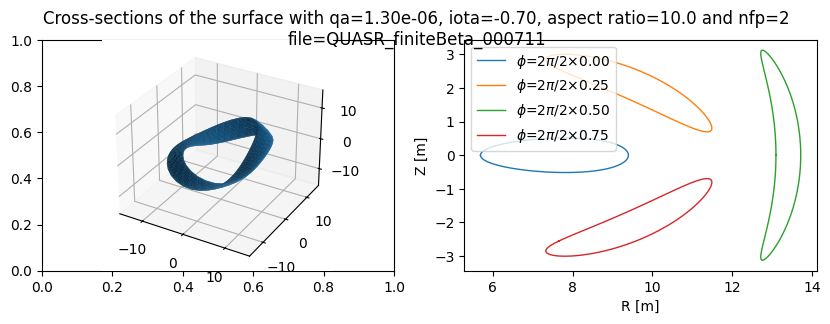

In [295]:
quantity = 'qa'#'well'#'fixed_grad_Q_avgs_divided_by_FSA_grad_x'#qi, qa, qp, qh, aspect_ratio
row = df[quantity].idxmin()
# row = df[quantity].idxmax()
# print(f"The ID with the value of {quantity} of {df[quantity].iloc[row]} is: {row}")
# print(df['file'].iloc[row])
row_data = df.iloc[row]

quadpoints_phi = np.linspace(0, 1, 50, endpoint=True)
quadpoints_theta = np.linspace(0, 1, 40*int(row_data['nfp']), endpoint=True)
surf = SurfaceRZFourier(nfp=int(row_data['nfp']),mpol=8,ntor=8,quadpoints_phi=quadpoints_phi,quadpoints_theta=quadpoints_theta)
mode_names = [f"rbc_{m}_{n}" for m in range(0, 9) for n in range(-8, 9)] + \
             [f"zbs_{m}_{n}" for m in range(0, 9) for n in range(-8, 9)]
mode_names = [name for name in mode_names if name in df.columns]
surf_x = row_data[mode_names].values.astype(float)
surf.x = surf_x

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
# axs[0].axis('off')
surf.plot(ax=axs[0], show=False)
for phi in np.linspace(0,2*np.pi/int(row_data['nfp']), 4, endpoint=False):
    cross_section = surf.cross_section(phi=phi)
    axs[1].plot(np.sqrt(cross_section[:, 0] ** 2 + cross_section[:, 1] ** 2), cross_section[:, 2], linewidth=1, label=rf"$\phi$=2$\pi$/{int(row_data['nfp'])}$\times${phi/2/np.pi*row_data['nfp']:.2f}")
axs[1].set_xlabel("R [m]")
axs[1].set_ylabel("Z [m]")
axs[1].legend()
fig.suptitle((f"Cross-sections of the surface with {quantity}={df[quantity].iloc[row]:.2e}, iota={row_data['mean_iota']:.2f}, aspect ratio={row_data['aspect_ratio']:.1f} and nfp={int(row_data['nfp'])}\n"
          +f"file={row_data['file']}"))

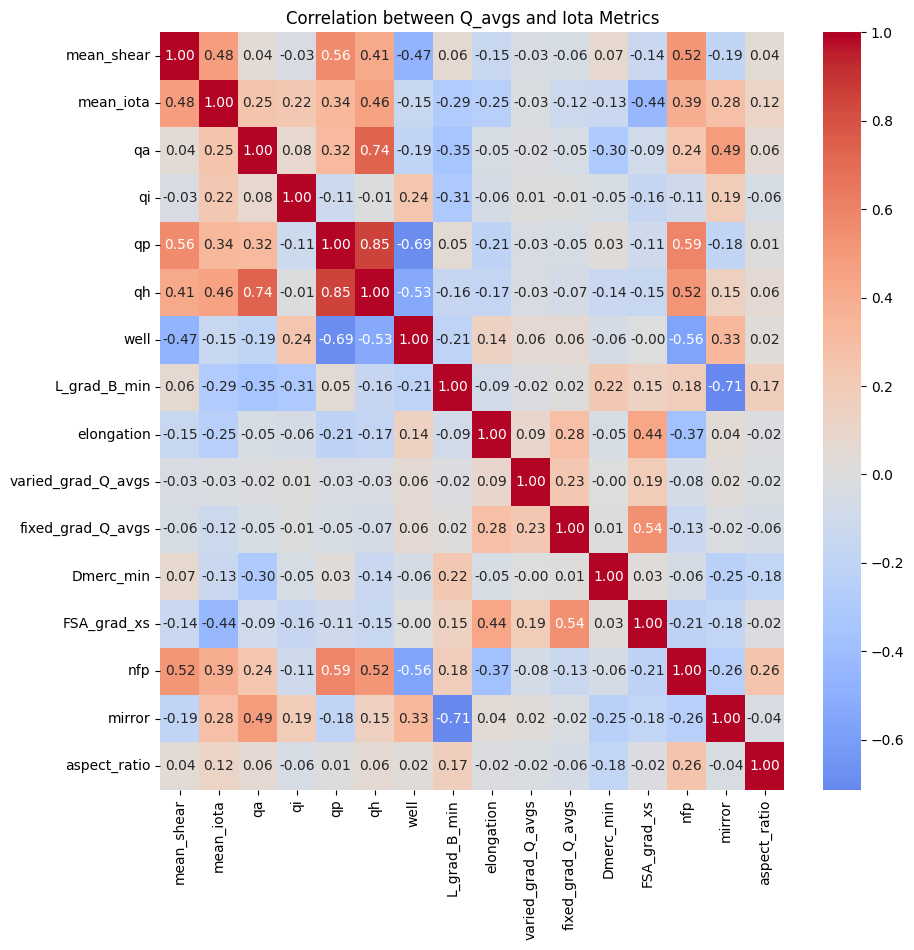

In [296]:

# Step 1: Identify relevant columns
cols = ["mean_shear", "mean_iota", "qa", "qi", "qp", "qh", "well","L_grad_B_min",
        "elongation","varied_grad_Q_avgs","fixed_grad_Q_avgs","Dmerc_min","FSA_grad_xs",
        "nfp","mirror","aspect_ratio"]

# Step 2: Subset the DataFrame
sub_df = df[cols].copy()

# Step 3: Drop any rows with NaNs (optional but recommended)
sub_df = sub_df.dropna()

# Step 4: Compute the correlation matrix
corr = sub_df.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(len(corr.columns)*0.6, len(corr.columns)*0.6))
sns.heatmap(corr.loc[cols, cols], annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation between Q_avgs and Iota Metrics")
plt.tight_layout()
plt.show()